<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/logo_mt_0_0.png" WIDTH=150 HEIGHT=150>
</div>
<div id="subject">
</br>

# Projet  | Analyse du mouvement
F4B305A | 2018-2019 <br/>
<span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span>
| <span style="color:blue">ronan.fablet@imt-atlantique.fr</span>

#### ===== Objectif du projet =====
Mettre en oeuvre la méthodologie décrite dans l'article et l'appliquer dans le contexte du tracking visuel d'objets vidéo au sein de séquences d'images. En particulier, l'application visée consiste à estimer pour l'ensemble de la séquence l'emplacement d'une région d'intérêt définie manuellement dans la première image, dite image de référence.

Les développement se feront en langage python et peuvent utiliser des fonctions issues des librairies openCV et scikit-image. 

In [1]:
import numpy as np
import cv2
from skimage import io
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import img_as_ubyte
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel

#### ===== Données =====
Vous disposez de 6 séquences vidéos - contenant un nombre variable d'images (>50) - avec lesquelles vous pourrez tester votre méthode et la comparer avec les approches mises en oeuvre par les autres groupes du projet.

Les séquences (bag, book, camel, cows, rhino, swan) sont disponibles ici : https://www.dropbox.com/s/m1yj44stb4djum3/F4B305A-sequences-1.zip?dl=0

A chaque image est associé un masque binaire permettant de localiser l'objet d'intérêt. Excepté pour l'image de référence, les masques fournis ne pourront être utilisés que pour l'évaluation de la méthode implémentée. 

De nouvelles séquences seront fournies en fin de module.

In [2]:
name = 'swan' # nom de séquence : bag, book, camel, cows, rhino, swan

im_begin, im_end = 1, 26                 # image de référence (1) et dernière image (varie selon les séquences)
output_folder = './../results/'+name+'/' # dossier résultats
distutils.dir_util.mkpath(output_folder) # création du dossier output_folder

['..\\results', '..\\results\\swan']

Visualisons quelques images et masques vérité-terrain associés :

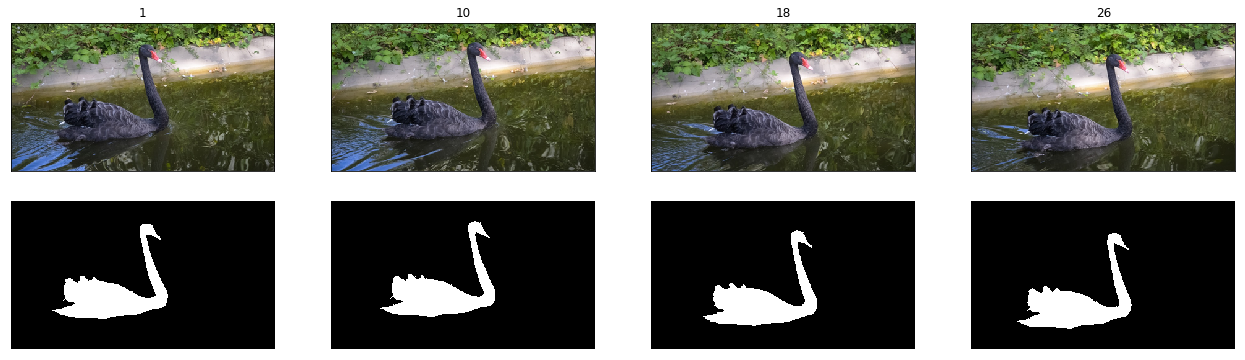

In [4]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([1,10,18,26]):
    img_current = io.imread('F4B305A-sequences-1/'+name+'/%0*d.bmp'%(3,im))
    mask_current = io.imread('F4B305A-sequences-1/'+name+'/%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

#### ===== Evaluation =====

Les fonctions DICE_assessment(), db_eval_boundary() et centroid_assessment() fournies ci-dessous permettront d'évaluer la méthode mise en oeuvre. Ces fonctions prennent en entrées le masque verité-terrain de l'objet d'intérêt ainsi que le masque estimé. 

DICE_assessment() évalue le recouvrement entre les deux masques tandis que db_eval_boundary() quantifie la qualité des contours estimés. Chacune des fonctions renvoie un score entre 0 (mauvaise qualité) et 100 (qualité parfaite).

centroid_assessment() calcule la distance euclidienne entre centroids vérité-terrain et estimé.

In [7]:
def DICE_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [5]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(np.bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

In [8]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

#### ===== Baseline =====

Le code ci-dessous montre - à titre indicatif - la mise en oeuvre d'une méthodologie possible (parmi d'autres) pour répondre aux exigences du projet. 

Considérons une séquence de $N+1$ images RGB $\{I_{n}\}$ avec $n\in \{0,\ldots,N\}$ où $I_{0}$ est l'image dite de référence. Nous estimons ici le mouvement long-terme entre chaque image $I_{n}$ avec $n \neq 0$ et l'image de référence $I_{0}$ par l'intermédiaire d'un estimateur de flot optique qui traite les paires $\{I_{n},I_{0}\}$ indépendemment.

Dans cet exemple, une implémentation openCV de l'estimateur de flot optique de Farnebäck (G. Farnebäck, “Two-frame motion estimation based on polynomial expansion,” Image Analysis, pp. 363–370, 2003) est utilisé.


In [9]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

Une fois les champs de flot optique estimés, la fonction propagate_mask() ci-dessous propage le masque de segmentation vérité-terrain de $I_{0}$ vers $I_{n}$.

In [10]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(np.int), np.rint(y+flow[x,y,0]).astype(np.int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

In [13]:
img_begin = io.imread('./F4B305A-sequences-1/'+name+'/%0*d.bmp'%(3,im_begin))
mask_begin = io.imread('./F4B305A-sequences-1/'+name+'/%0*d.png'%(3,im_begin))

dices, fmeasures, centroid_dist, visu = [], [], [], []
for im in range(im_begin+1,im_end+1):
    print(im)
    img_current = io.imread('./F4B305A-sequences-1/'+name+'/%0*d.bmp'%(3,im))
    mask_current = io.imread('./F4B305A-sequences-1/'+name+'/%0*d.png'%(3,im))
    flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
    propagation = propagate_mask(flow, img_current, mask_begin)
    io.imsave(output_folder+'prop-%0*d.png'%(3,im), propagation)
    visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation, color=(1,0,0)))
    io.imsave(output_folder+'bound-%0*d.bmp'%(3,im), visu[-1])
    dices.append(DICE_assessment(mask_current, propagation))
    fmeasures.append(db_eval_boundary(mask_current, propagation))
    centroid_dist.append(centroid_assessment(mask_current, propagation))

2


C:\Users\BOURKHISS\AppData\Roaming\Python\Python36\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


#### ===== Visualisation des résultats =====

Une fois votre méthode mise en oeuvre, vous pourrez afficher l'évolution des scores DICE, F-measure et distance entre centroids le long des séquences vidéo...

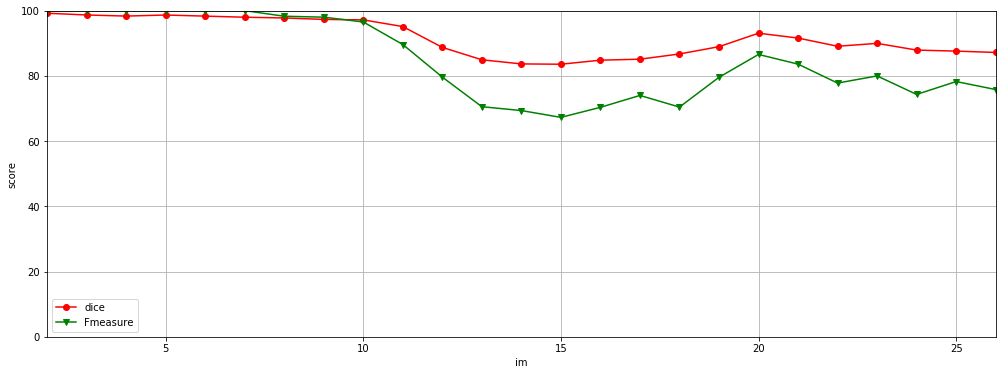

In [14]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,dices,marker='o',color='r')
plt.plot(x,fmeasures,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
plt.savefig(output_folder+'eval.png')
plt.show()

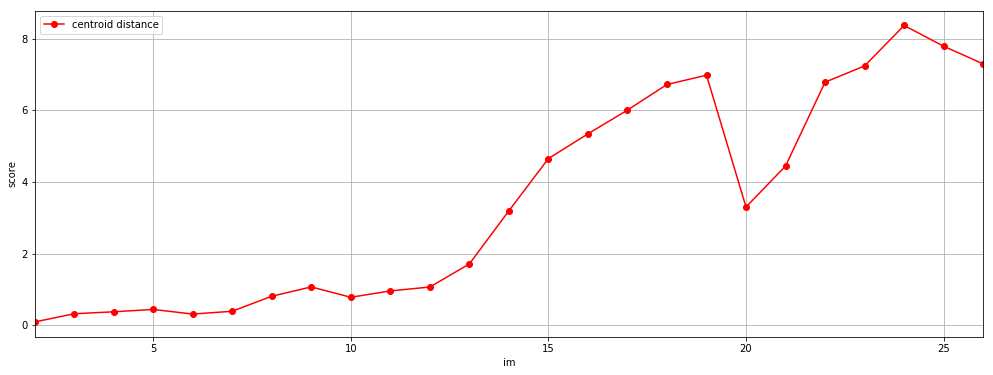

In [15]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,centroid_dist,marker='o',color='r')
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['centroid distance'])
plt.savefig(output_folder+'eval-centroid.png')
plt.show()

... et visualiser les résultats de tracking obtenus !

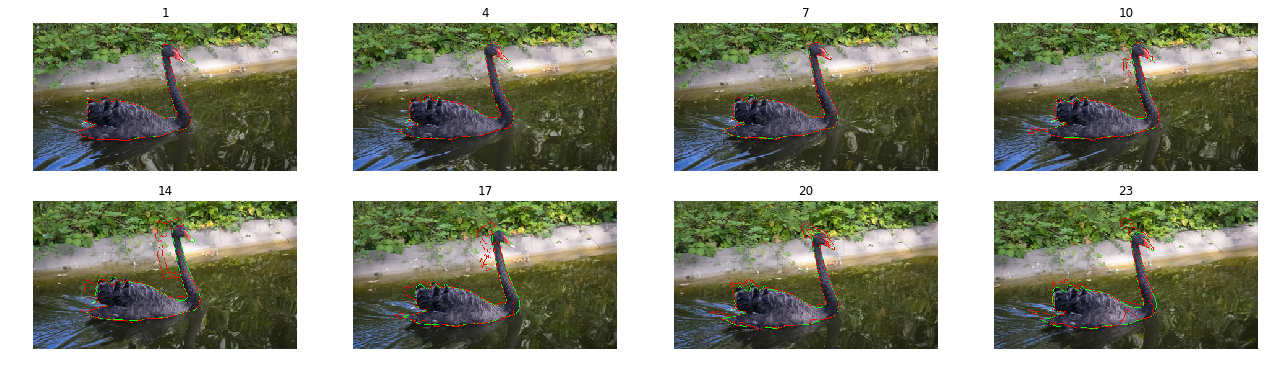

In [16]:
plt.figure()
plt.figure(figsize=(22, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    im = np.int(np.floor(i*(im_end/8)+im_begin-1))
    plt.imshow(visu[im])
    plt.title('%i' %(im+1))
plt.show()

#### ===== Décomposition en superpixels =====

Les superpixels sont des primitives visuelles générées par l’agrégation de pixels voisins partageant des caractéristiques similaires. Cet outil pourra être exploité au cours du projet. Un exemple de décomposition à l'aide des méthodes Felzenszwalb, SLIC, Quickshift et Watershed est fourni ci-dessous :

Felzenszwalb number of segments: 320
SLIC number of segments: 219
Quickshift number of segments: 530


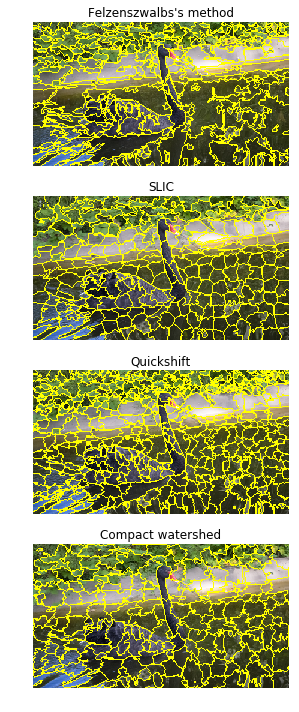

In [17]:
segments_fz = felzenszwalb(img_begin, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img_begin, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(img_begin, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img_begin))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print('Felzenszwalb number of segments: {}'.format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(4, figsize=(10, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(mark_boundaries(img_begin, segments_fz))
ax[0].set_title("Felzenszwalbs's method")
ax[1].imshow(mark_boundaries(img_begin, segments_slic))
ax[1].set_title('SLIC')
ax[2].imshow(mark_boundaries(img_begin, segments_quick))
ax[2].set_title('Quickshift')
ax[3].imshow(mark_boundaries(img_begin, segments_watershed))
ax[3].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()